In [1]:
import bisect
import pandas as pd
import numpy as np

%pylab inline
import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import mstats

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Retrieve Data Set
df = pd.read_csv('http://www.dataminingconsultant.com/data/churn.txt')

# Some Prepreocessing
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

state_encoder = LabelEncoder()
df.state = state_encoder.fit_transform(df.state)

del df['phone']

binary_columns = ['intl_plan', 'vmail_plan', 'churn']
for col in binary_columns:
    df[col] = df[col].map({
            'no': 0
        ,   'False.': 0
        ,   'yes': 1
        ,   'True.': 1
    })

df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


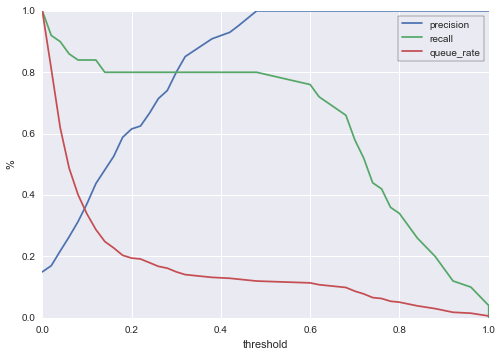

In [23]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
clf.fit(train_signals, train_labels)
predictions = clf.predict_proba(test_signals)[:,1]

precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
thresholds = np.append(thresholds, 1)

queue_rate = []
for threshold in thresholds:
    queue_rate.append((predictions >= threshold).mean())
    
plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

In [27]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

n_trials = 50
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

plot_data = []

for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)
    
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())
            
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })    

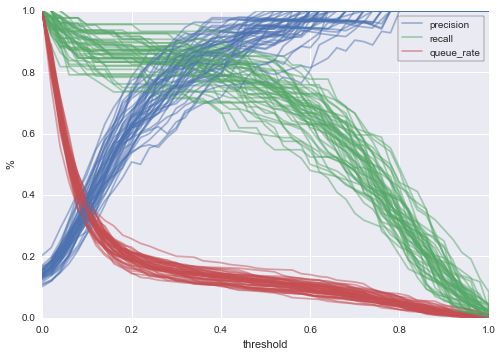

In [28]:
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)
    
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

In [6]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []
uniform_recall_plots= []
uniform_queue_rate_plots= []

for p in plot_data:
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])
        
    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

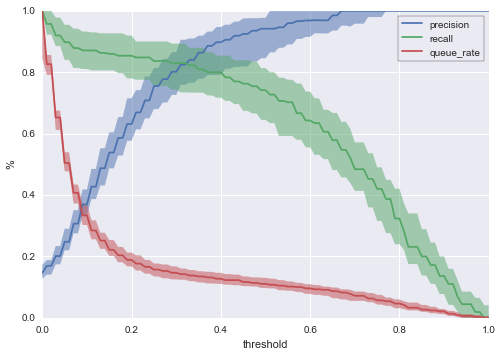

In [29]:
quantiles = [0.1, 0.5, 0.9]
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)
plt.plot(uniform_thresholds, median_recall)
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

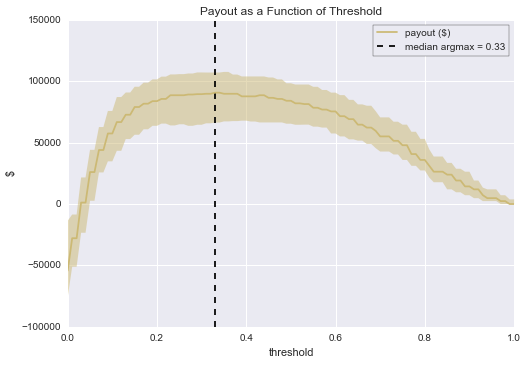

In [30]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000
success_payoff = 100
case_cost = 20

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]
plt.vlines([max_ap], -100000, 150000, linestyles='--')
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('$')

In [86]:
print np.max(median_payout)

90718.5628743


In [83]:
g.bbox_inches